In [1041]:
### IMPORTS ###
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import ipywidgets as widgets

In [1042]:
### SETTINGS ###
np.set_printoptions(precision=3, suppress=True, threshold=np.inf)

In [1043]:
### FOLDER SETTINGS ###
input_folder = "../output/"
output_folder = "output/"

file_solution_path = input_folder + "/system_solution.dat"  # Replace with your actual file path

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [1044]:
format_string = '<d'  # '<d' for little-endian, '>d' for big-endian

In [1045]:
### Analytical solution functions ###

# This function creates a ND numpy array
def np_u_analytical_poisson(ndims, global_domain_begin, global_domain_end, grid_size):
    # Create coordinate arrays for each dimension
    p_coords = [np.linspace(global_domain_begin[i], global_domain_end[i], grid_size[i]) for i in range(ndims)]
    
    # Generate meshgrid from coordinate arrays
    meshgrid = np.meshgrid(*p_coords, indexing='ij')
    
    # Compute function values
    func_val = np.prod(np.sin(np.pi * np.stack(meshgrid)),axis=0)
    
    return func_val, meshgrid

In [1046]:
### PLOTTING FUNCTIONS ###

def plot_1D(true_solution, approximate_solution, error):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    x_values = np.arange(len(true_solution))

    # True solution plot
    axes[0].plot(x_values, true_solution, color='blue', label='True Solution')
    axes[0].set_title('True Solution')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()

    # Approximate solution plot
    axes[1].plot(x_values, approximate_solution, color='green', label='Approximate Solution')
    axes[1].set_title('Approximate Solution')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    axes[1].legend()

    # Error plot
    axes[2].plot(x_values, error, color='red', label='Error')
    axes[2].set_title('Error')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def plot_2D(true_solution, approximate_solution, error):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # True solution plot
    cax1 = axes[0].imshow(true_solution, cmap='viridis', origin='lower')
    axes[0].set_title('True Solution')
    fig.colorbar(cax1, ax=axes[0], orientation='vertical')

    # Approximate solution plot
    cax2 = axes[1].imshow(approximate_solution, cmap='viridis', origin='lower')
    axes[1].set_title('Approximate Solution')
    fig.colorbar(cax2, ax=axes[1], orientation='vertical')

    # Error plot
    cax3 = axes[2].imshow(error, cmap='hot', origin='lower')
    axes[2].set_title('Error')
    fig.colorbar(cax3, ax=axes[2], orientation='vertical')

    plt.tight_layout()
    plt.show()

def plot_slice_3D(true_solution, approximate_solution, error, z_index=0):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # True solution plot for the given slice
    cax1 = axes[0].imshow(true_solution[:, :, z_index], cmap='viridis', origin='lower')
    axes[0].set_title(f'True Solution (Slice at z={z_index})')
    fig.colorbar(cax1, ax=axes[0], orientation='vertical')

    # Approximate solution plot for the given slice
    cax2 = axes[1].imshow(approximate_solution[:, :, z_index], cmap='viridis', origin='lower')
    axes[1].set_title(f'Approximate Solution (Slice at z={z_index})')
    fig.colorbar(cax2, ax=axes[1], orientation='vertical')

    # Error plot for the given slice
    cax3 = axes[2].imshow(error[:, :, z_index], cmap='hot', origin='lower')
    axes[2].set_title(f'Error (Slice at z={z_index})')
    fig.colorbar(cax3, ax=axes[2], orientation='vertical')

    plt.tight_layout()
    plt.show()

In [1047]:
with open(file_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)

    approximate_solution = data

approximate_solution = np.array(approximate_solution)

In [1048]:
#print(approximate_solution)

In [1049]:
ndims = 2
grid_size = int(math.ceil((approximate_solution.size) ** (1 / ndims)))

grid_size_array = np.full(ndims, grid_size)
print("Grid size: ", grid_size_array)

Grid size:  [16 16]


In [1050]:
domain_begin_array = np.full(ndims, 0.0)
domain_end_array = np.full(ndims, 1.0)

In [1051]:
# Reshape the data into a 2D array
approximate_solution = np.array(approximate_solution)
approximate_solution = approximate_solution.reshape(grid_size_array)

In [1052]:
#print(approximate_solution)

In [1053]:
true_solution, mesh = np_u_analytical_poisson(ndims, domain_begin_array, domain_end_array, grid_size_array)

error = np.abs(approximate_solution - true_solution)
print("Max error: ", np.max(error))
print("Mean error: ", np.mean(error))
print("Std dev error: ", np.std(error))


Max error:  2.881475449270643e-05
Mean error:  1.5028004963933906e-05
Std dev error:  9.31760775327299e-06


In [1054]:
if(ndims == 1):
    plot_1D(true_solution, approximate_solution, error)

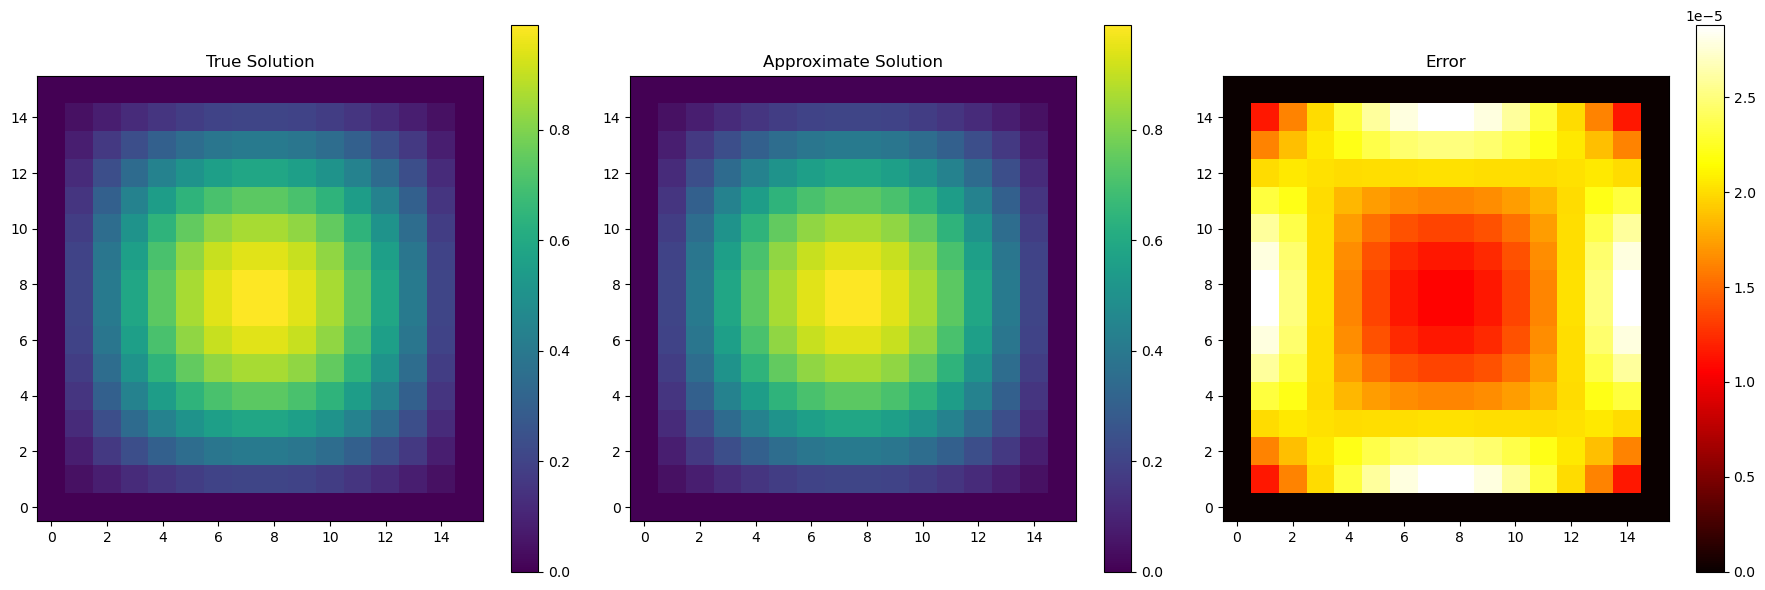

In [1055]:
if(ndims == 2):
    plot_2D(true_solution, approximate_solution, error)

In [1056]:
if(ndims == 3):
    # Adjust the max value of the slider to match the size of your 3rd dimension
    z_slider = IntSlider(min=0, max=true_solution.shape[-1]-1, step=1, value=0, description='Z index')

    # Use 'fixed' for non-interactive arguments
    interact(plot_slice_3D, true_solution=fixed(true_solution), approximate_solution=fixed(approximate_solution), error=fixed(error), z_index=z_slider)